You need reload to enable change in the logging level without restarting the kernel

In [79]:
import importlib
import logging
from matplotlib import pyplot as plt
importlib.reload(logging);

### Setting logging level

In [8]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

### Basic imports and setting tmp location

In [9]:
import os
import tempfile
from pprint import pprint  # pretty-printer
from collections import defaultdict
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

Folder "/var/folders/9x/cd3tjw3s5yvghvt6z_ls6fn00000gn/T" will be used to save temporary dictionary and corpus.


### GenSim data types

In [10]:
from gensim import corpora, models

#### Corpus and dictionary creation in memory 

In [32]:
documents = ["Human machine interface for lab abc computer applications",
             "A survey of user opinion of computer system response time",
             "The EPS user interface management system",
             "System and human system engineering testing of EPS",              
             "Relation of user perceived response time to error measurement",
             "The generation of random binary unordered trees",
             "The intersection graph of paths in trees",
             "Graph minors IV Widths of trees and well quasi ordering",
             "Graph minors A survey"]

**Step 1:** convert documents to tokens (remove stop words and words with frequency = 1)

In [33]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

pprint(texts)

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]


**Step 2:** Create and save dictonary using the token generated in Step 1

In [34]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'deerwester.dict'))  # store the dictionary, for future reference
print(dictionary)

Dictionary(12 unique tokens: ['computer', 'time', 'human', 'response', 'survey']...)


In [16]:
print(dictionary.token2id)

{'computer': 0, 'time': 6, 'human': 1, 'response': 3, 'survey': 4, 'minors': 11, 'user': 7, 'system': 5, 'eps': 8, 'graph': 10, 'trees': 9, 'interface': 2}


Converting a new documents to Bag of words, based on dictionary created 

In [17]:
new_doc = "Human computer interaction"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)  # the word "interaction" does not appear in the dictionary and is ignored

[(0, 1), (1, 1)]


**Step 3:** Create and save serialized corpora on entire tokenized text

In [35]:
corpus = [dictionary.doc2bow(text) for text in texts]
for c in corpus:
    print(c)
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'deerwester.mm'), corpus)  # store to disk, for later use

[(0, 1), (1, 1), (2, 1)]
[(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(2, 1), (5, 1), (7, 1), (8, 1)]
[(1, 1), (5, 2), (8, 1)]
[(3, 1), (6, 1), (7, 1)]
[(9, 1)]
[(9, 1), (10, 1)]
[(9, 1), (10, 1), (11, 1)]
[(4, 1), (10, 1), (11, 1)]


#### Corpus and dictionary creating from disk (streaming)

Create a python iterator that will yield one line at a time

In [12]:
class MyCorpus(object):
    def __iter__(self):
        for line in open('deerwester.txt'):
            yield dictionary.doc2bow(line.lower().split())

In [13]:
mem_friendly_corpus = MyCorpus()

In [14]:
for vector in mem_friendly_corpus:
    print(vector)

[(0, 1), (2, 1)]
[(0, 1), (3, 1), (4, 1), (5, 1), (7, 1)]
[(2, 1), (7, 1), (8, 1)]
[(1, 1), (5, 1)]
[(3, 1), (6, 1), (7, 1)]
[]
[(10, 1)]
[(9, 1), (11, 1)]
[(11, 1)]


**Step 1:** Creating a dictionary from the raw text documents on disk (Streaming corpus)

In [19]:
from six import iteritems
dictionary = corpora.Dictionary(line.lower().split() for line in open('deerwester.txt'))
stop_ids = [
     dictionary.token2id[stopword]
     for stopword in stoplist
     if stopword in dictionary.token2id
]
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids)
dictionary.compactify()

In [20]:
# saving a dictionary
dictionary.save("deerwester.dict")

**Step 2:** Create the corpus 

In [21]:
dictionary = corpora.Dictionary.load('deerwester.dict')
corpus = corpora.MmCorpus(os.path.join(TEMP_FOLDER, 'deerwester.mm'))

**Step 3:** Calculate tf-idf on model's corpus.

In [22]:
tfidf = models.TfidfModel(corpus)  

In [19]:
# Pretty Printing documents frequncies of each word)
tfidf.dfs

{0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 3, 6: 2, 7: 3, 8: 2, 9: 3, 10: 3, 11: 2}

In [20]:
# Pretty Printing tf-idf of each word)
tfidf.idfs

{0: 2.1699250014423126,
 1: 2.1699250014423126,
 2: 2.1699250014423126,
 3: 2.1699250014423126,
 4: 2.1699250014423126,
 5: 1.5849625007211563,
 6: 2.1699250014423126,
 7: 1.5849625007211563,
 8: 2.1699250014423126,
 9: 1.5849625007211563,
 10: 1.5849625007211563,
 11: 2.1699250014423126}

In [21]:
doc = [(9, 1), (11, 1)]
tfidf[doc]

[(9, 0.5898341626740045), (11, 0.8075244024440723)]

In [23]:
for doc in tfidf[corpus]:
    print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(0, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.44424552527467476), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.3244870206138555)]
[(2, 0.5710059809418182), (5, 0.4170757362022777), (7, 0.4170757362022777), (8, 0.5710059809418182)]
[(1, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (6, 0.6282580468670046), (7, 0.45889394536615247)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(4, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


### GenSim LDA

In [39]:
corpus_tfidf = tfidf[corpus]
corpus_tfidf

#### 2 topics LDA

In [84]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=2)
lda.print_topics()

2019-09-03 20:28:22,883 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


[(0,
  '0.179*"graph" + 0.125*"minors" + 0.121*"trees" + 0.097*"survey" + 0.082*"interface" + 0.070*"user" + 0.067*"system" + 0.064*"eps" + 0.050*"human" + 0.050*"computer"'),
 (1,
  '0.152*"system" + 0.113*"user" + 0.088*"response" + 0.087*"time" + 0.086*"computer" + 0.086*"human" + 0.084*"trees" + 0.078*"eps" + 0.068*"interface" + 0.060*"survey"')]

Printing document topics for the training corpus

In [81]:
topic0 = []
topic1 = []
for doc in corpus:
    topic0 = topic0 + [lda.get_document_topics(doc)[0][1]]
    topic1 = topic1 + [lda.get_document_topics(doc)[1][1]]
    

In [82]:
colors = []
for t1, t2 in zip(topic0, topic1):
    if t1 > t2:
        colors += ['r']
    else:
        colors += ['b']

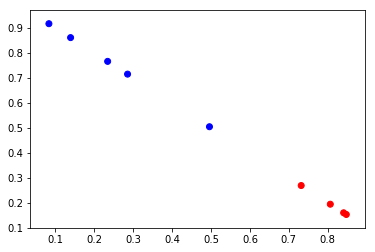

In [83]:
plt.scatter(topic0, topic1, color = colors)
plt.show()

#### 3 topics LDA
    

In [85]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=3)
lda.print_topics()

2019-09-03 20:28:33,842 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


[(0,
  '0.180*"graph" + 0.131*"trees" + 0.126*"survey" + 0.125*"minors" + 0.076*"user" + 0.075*"system" + 0.075*"time" + 0.074*"computer" + 0.072*"response" + 0.022*"human"'),
 (1,
  '0.203*"trees" + 0.084*"user" + 0.077*"system" + 0.076*"computer" + 0.075*"response" + 0.073*"survey" + 0.072*"graph" + 0.071*"minors" + 0.070*"time" + 0.068*"human"'),
 (2,
  '0.183*"system" + 0.128*"eps" + 0.126*"interface" + 0.125*"human" + 0.123*"user" + 0.074*"response" + 0.073*"time" + 0.071*"computer" + 0.030*"trees" + 0.024*"graph"')]

In [86]:
topic0 = []
topic1 = []
topic2 = []
for doc in corpus:
    topic0 = topic0 + [lda.get_document_topics(doc)[0][1]]
    topic1 = topic1 + [lda.get_document_topics(doc)[1][1]]
    topic2 = topic2 + [lda.get_document_topics(doc)[2][1]]
    

In [90]:
cmap = {0: 'r', 1:'b', 2:'y'}
colors = []
for z in zip(topic0, topic1, topic2):
    topic = z.index(max(z)) 
    print(z, topic)
    colors += [cmap[topic]]
    

(0.088597655, 0.086161725, 0.8251816) 2
(0.52867585, 0.05005382, 0.4212831) 0
(0.068983085, 0.06815253, 0.86286736) 2
(0.068428285, 0.067867324, 0.86370385) 2
(0.100871176, 0.08750589, 0.8114843) 2
(0.20387703, 0.62754726, 0.16847794) 1
(0.76012784, 0.12779652, 0.1120917) 0
(0.82488304, 0.09114798, 0.08397666) 0
(0.8311661, 0.08507178, 0.083764546) 0


In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topic0, topic1, topic2, color = colors)
plt.show()

ValueError: Unknown projection '3d'